# Local notebook - First approach

In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import spacy
from spacy.util import compounding
from spacy.util import minibatch

import os
import random

from tqdm import tqdm

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
stemmer = PorterStemmer()

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer() 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pmbrull/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pmbrull/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## EDA

In [283]:
raw_df = pd.read_csv('../data/train.csv')
raw_df.head()

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive


In [284]:
raw_df.shape

(27486, 4)

In [285]:
# remove missing values
raw_df = raw_df.dropna()
raw_df.shape

(27485, 4)

### Sentiment Distribution

In [286]:
print(raw_df['sentiment'].value_counts().values)
print(raw_df['sentiment'].unique())

[11117  8582  7786]
['neutral' 'positive' 'negative']


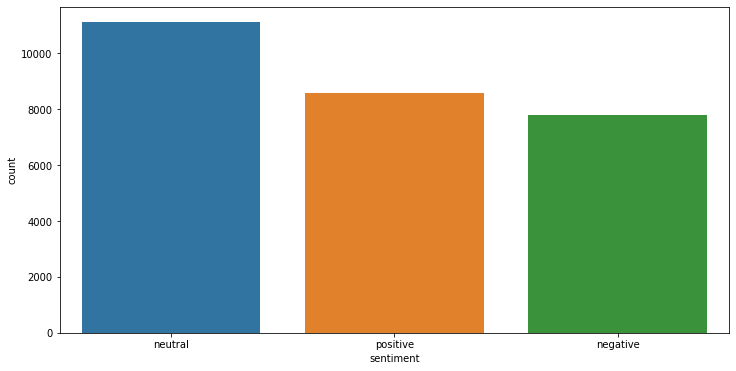

In [287]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment', data=raw_df)

In [288]:
# Let's check one example of each:
print("Positive:",raw_df[raw_df['sentiment']=='positive']['text'].values[0])
print("Negative:",raw_df[raw_df['sentiment']=='negative']['text'].values[0])
print("Neutral:",raw_df[raw_df['sentiment']=='neutral']['text'].values[0])

Positive:  Oh! Good idea about putting them on ice cream
Negative:  i dont think you can vote anymore! i tried
Neutral: Spent the entire morning in a meeting w/ a vendor, and my boss was not happy w/ them. Lots of fun.  I had other plans for my morning


In [289]:
# We could try to guess which words would be selected in the positive and negative case:
# For positive we could say "Good idea"
# For negative: "i dont think"
print("Positive:",raw_df[raw_df['sentiment']=='positive']['selected_text'].values[0])
print("Negative:",raw_df[raw_df['sentiment']=='negative']['selected_text'].values[0])
print("Neutral:",raw_df[raw_df['sentiment']=='neutral']['selected_text'].values[0])

Positive: Good
Negative: i dont think you can vote anymore!
Neutral: my boss was not happy w/ them. Lots of fun.


In [290]:
# all in all, somehow accurate

## Preprocess

In [291]:
def text_to_words(text, return_list=True):
    lower = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    words = lower.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    # words = [PorterStemmer().stem(w) for w in words] # stem
    words = [lemmatizer.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 1]
    words = ' '.join(words)
    
    return words

def get_cache(cache_dir, cache_file):
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pd.read_pickle(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
        
    return cache_data

def clean_data(df):
    clean_text = df['text'].apply(text_to_words)
    clean_extracted_text = df['selected_text'].apply(text_to_words)

    clean_df = pd.DataFrame({
        'textID': df['textID'],
        'text': clean_text,
        'selected_text': clean_extracted_text,
        'sentiment': df['sentiment']
    })
    
    return clean_df

def preprocess_df(df, cache_dir='../cache', cache_file="clean_data.pkl"):
    
    os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists
    
    cache_data = get_cache(cache_dir, cache_file)
    
    if cache_data is None:
        cache_data = clean_data(df)
        cache_data.to_pickle(os.path.join(cache_dir, cache_file))

    return cache_data

In [292]:
# clean_df = preprocess_df(raw_df)
clean_df = preprocess_df(raw_df)

Read preprocessed data from cache file: clean_data.pkl


In [316]:
# Remove empty selected text, usually due to just composed by characters
clean_df = clean_df.loc[clean_df['selected_text'] != '']

In [317]:
clean_df.head()

,textID,text,selected_text,sentiment
1,251b6a6766,oh good idea putting ice cream,good,positive
3,f14f087215,dont think vote anymore tried,dont think vote anymore,negative
4,bf7473b12d,haha better drunken tweeting mean,better,positive
5,1915bebcb3,headache wanna see julie,headache,negative
6,2ab82634d5,awsome salad recommend getting spicey buffalo ...,awsome salad,positive


## Extract Features from the text

In [ ]:
#source of code : https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
pos_unigrams = get_top_n_words(clean_df.loc[clean_df['sentiment'] == 'positive']['selected_text'], 10)
neg_unigrams = get_top_n_words(clean_df.loc[clean_df['sentiment'] == 'negative']['selected_text'], 10)
neutral_unigrams = get_top_n_words(clean_df.loc[clean_df['sentiment'] == 'neutral']['selected_text'], 10)

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = [x[0] for x in pos_unigrams]
y = [x[1] for x in pos_unigrams]ref
ax.bar(x,y)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = [x[0] for x in neg_unigrams]
y = [x[1] for x in neg_unigrams]
ax.bar(x,y)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = [x[0] for x in neutral_unigrams]
y = [x[1] for x in neutral_unigrams]
ax.bar(x,y)
plt.show()

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white", colormap="viridis")\
    .generate(" ".join(clean_df.loc[clean_df['sentiment'] == 'positive']['text']))
fig = plt.figure(figsize=(10,4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
fig.suptitle('Positive Text', fontsize=20)
plt.show()

In [ ]:
wordcloud = WordCloud(background_color="white", colormap="inferno")\
    .generate(" ".join(clean_df.loc[clean_df['sentiment'] == 'negative']['text']))
fig = plt.figure(figsize=(10,4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
fig.suptitle('Negative Text', fontsize=20)
plt.show()

In [ ]:
wordcloud = WordCloud(background_color="white", colormap="terrain")\
    .generate(" ".join(clean_df.loc[clean_df['sentiment'] == 'neutral']['text']))
fig = plt.figure(figsize=(10,4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
fig.suptitle('Neutral Text', fontsize=20)
plt.show()

## Text lengths

In [ ]:
clean_df['text_word_count'] = clean_df['text'].apply(lambda x: len(str(x).split()))
clean_df['selected_text_word_count'] = clean_df['selected_text'].apply(lambda x: len(str(x).split()))
clean_df.head()

In [ ]:
clean_df.loc[clean_df['sentiment'] == 'positive'][['text_word_count', 'selected_text_word_count']].mean()

In [ ]:
clean_df.loc[clean_df['sentiment'] == 'negative'][['text_word_count', 'selected_text_word_count']].mean()

In [ ]:
clean_df.loc[clean_df['sentiment'] == 'neutral'][['text_word_count', 'selected_text_word_count']].mean()

## Partition Data - Keep only pos and neg

In [320]:
from sklearn.model_selection import train_test_split

clean_df = clean_df.loc[clean_df['sentiment'] != 'neutral']

clean_y = clean_df['selected_text']
clean_train_df = clean_df.drop('selected_text', axis=1)

X_train, X_val, y_train, y_val = train_test_split(clean_train_df, clean_y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(12933, 3) (12933,)
(3234, 3) (3234,)


## Benchmark Model - NER


In [322]:
def save_model(output_dir, nlp, new_model_name):
    output_dir = f'../working/{output_dir}'
    if output_dir is not None:        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

In [323]:
def train(train_data, output_dir, n_iter=20, model=None):
    """Load the model, set up the pipeline and train the entity recognizer."""
    
    if model is not None:
        nlp = spacy.load(output_dir)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
    
    # add labels
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        # sizes = compounding(1.0, 4.0, 1.001)
        # batch up the examples using spaCy's minibatch
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()


        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))    
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts,  # batch of texts
                            annotations,  # batch of annotations
                            drop=0.5,   # dropout - make it harder to memorise data
                            losses=losses, 
                            )
            print("Losses", losses)
    save_model(output_dir, nlp, 'st_ner')

In [324]:
def get_model_out_path(sentiment):
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = 'models/model_pos'
    elif sentiment == 'negative':
        model_out_path = 'models/model_neg'
    return model_out_path

In [325]:
## creating data in spacy data input format

def get_training_data(df):
    train_data = []
    for index, row in df.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

### TRAIN

In [326]:
X_train['selected_text'] = y_train
X_train.head()

/home/pmbrull/venv/vner/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,textID,text,sentiment,selected_text
22822,f94af8cb85,much better tool come across http www tweepula...,positive,much better tool
14445,96de84d102,like saddest person jtv right,negative,saddest
4929,328c362a0b,think come back brisbane australia loved,positive,loved
8014,e88d4be483,get chat oh well time eat praline,negative,get chat
2194,98cfd2075f,people idea depressing steakhouse able eat,negative,depressing steakhouse


In [105]:
# X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(raw_train_df, raw_y, test_size=0.2)

X_train_raw['selected_text'] = y_train_raw
X_train_raw.head()

/home/pmbrull/venv/vner/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,textID,text,sentiment,selected_text
27044,756b4e674b,Stupid competition stuff keeps getting in the ...,negative,Stupid competition stuff
19829,ecfc3c4122,I am beginning to think sun blcok is a haox.,negative,haox.
22526,4bf221814c,Snap. I'm the same with any reality show. Wat...,negative,Very sa
16610,ce1ac5a388,greeting again every momma : Happy Momma's Day!,positive,greeting again every momma : Happy Momma's Day!
14579,a9456542d7,Happy mother's day to all moms out there! i j...,positive,Happy


In [328]:
## Train positive

sentiment = 'positive'
train_positive_df = X_train.loc[X_train['sentiment'] == sentiment]

train_data = get_training_data(train_positive_df)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=10, model=None)

  0%|          | 0/10 [00:00<?, ?it/s]

Created blank 'en' model


 10%|█         | 1/10 [00:19<02:54, 19.40s/it]

Losses {'ner': 15273.011087310908}


 20%|██        | 2/10 [00:38<02:34, 19.32s/it]

Losses {'ner': 14469.76810618876}


 30%|███       | 3/10 [00:58<02:16, 19.51s/it]

Losses {'ner': 14073.24419212438}


 40%|████      | 4/10 [01:20<02:02, 20.34s/it]

Losses {'ner': 13589.363596024465}


 50%|█████     | 5/10 [01:40<01:40, 20.18s/it]

Losses {'ner': 13179.708280419893}


 60%|██████    | 6/10 [02:00<01:20, 20.22s/it]

Losses {'ner': 12924.299197079443}


 70%|███████   | 7/10 [02:28<01:06, 22.33s/it]

Losses {'ner': 12520.775182823032}


 80%|████████  | 8/10 [02:56<00:48, 24.05s/it]

Losses {'ner': 12490.921102098255}


 90%|█████████ | 9/10 [03:24<00:25, 25.24s/it]

Losses {'ner': 12520.07851177104}


100%|██████████| 10/10 [03:52<00:00, 23.24s/it]

Losses {'ner': 12167.914460011747}
Saved model to ../working/models/model_pos


In [330]:
sentiment = 'negative'
train_negative_df = X_train.loc[X_train['sentiment'] == sentiment]


train_data = get_training_data(train_negative_df)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=10, model=None)

  0%|          | 0/10 [00:00<?, ?it/s]

Created blank 'en' model


 10%|█         | 1/10 [00:18<02:49, 18.88s/it]

Losses {'ner': 14333.290231212508}


 20%|██        | 2/10 [00:37<02:30, 18.81s/it]

Losses {'ner': 12907.944787556276}


 30%|███       | 3/10 [00:55<02:10, 18.61s/it]

Losses {'ner': 12356.595063333429}


 40%|████      | 4/10 [01:15<01:53, 18.92s/it]

Losses {'ner': 11976.58942808477}


 50%|█████     | 5/10 [01:33<01:33, 18.72s/it]

Losses {'ner': 11488.797077280145}


 60%|██████    | 6/10 [01:51<01:13, 18.34s/it]

Losses {'ner': 11092.223902613972}


 70%|███████   | 7/10 [02:13<00:58, 19.66s/it]

Losses {'ner': 10888.878496573216}


 80%|████████  | 8/10 [02:39<00:42, 21.48s/it]

Losses {'ner': 10522.26824167232}


 90%|█████████ | 9/10 [03:05<00:22, 22.75s/it]

Losses {'ner': 10462.934786350363}


100%|██████████| 10/10 [03:31<00:00, 21.11s/it]

Losses {'ner': 10184.214839122727}
Saved model to ../working/models/model_neg


### PREDICT

In [331]:
model_pos = spacy.load('../working/models/model_pos')
model_neg = spacy.load('../working/models/model_neg')

In [332]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [333]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [334]:
selected_texts = []
for index, row in X_val.iterrows():
    text = row.text
    output_str = ""
    if row.sentiment == 'positive':
        selected_texts.append(predict_entities(text, model_pos))
    else:
        selected_texts.append(predict_entities(text, model_neg))
        
X_val['selected_text_pred'] = selected_texts

/home/pmbrull/venv/vner/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [335]:
X_val['selected_text'] = y_val

/home/pmbrull/venv/vner/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [336]:
X_val.head(10)

,textID,text,sentiment,selected_text_pred,selected_text
26479,73b49ab662,watching youtube vid sing paranoid live cute s...,positive,cute,cut
18529,9abcf3cb2c,aww sry yesterday,negative,aww sry yesterday,sry
17776,433cb03f2a,tummy hurt,negative,hurt,tummy hurt
10816,2736c303b4,finally friday still grounded till next thursd...,positive,finally friday still grounded till next thursd...,stereo life lt
22964,2fed83307e,least done,positive,least done,least done
25530,c609f49827,think tricked ankle cardio yesterday getting old,negative,think tricked ankle cardio yesterday getting old,tricked
16863,3696933f3b,awww thanks jon appreciate,positive,awww thanks jon appreciate,awww thanks jon appreciate
17099,ccf98809a7,wow hope get better cancer gtfo,positive,wow hope,wow hope get bette
15998,0676ff0933,happy mom day mom,positive,happy,happy
21880,fba650361b,thank,positive,thank,thank


In [337]:
X_val['score'] = X_val[['selected_text','selected_text_pred']].apply(lambda x: jaccard(*x), axis=1)
X_val.head()

/home/pmbrull/venv/vner/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,textID,text,sentiment,selected_text_pred,selected_text,score
26479,73b49ab662,watching youtube vid sing paranoid live cute s...,positive,cute,cut,0.000000
18529,9abcf3cb2c,aww sry yesterday,negative,aww sry yesterday,sry,0.333333
17776,433cb03f2a,tummy hurt,negative,hurt,tummy hurt,0.500000
10816,2736c303b4,finally friday still grounded till next thursd...,positive,finally friday still grounded till next thursd...,stereo life lt,0.272727
22964,2fed83307e,least done,positive,least done,least done,1.000000


In [338]:
# Final Score
X_val['score'].sum() / X_val.shape[0]

0.5362184584628107

In [339]:
# Positive Score
X_val.loc[X_val['sentiment'] == 'positive']['score'].sum() / X_val.loc[X_val['sentiment'] == 'positive'].shape[0]

0.56335648767548

In [340]:
# Negative Score
X_val.loc[X_val['sentiment'] == 'negative']['score'].sum() / X_val.loc[X_val['sentiment'] == 'negative'].shape[0]

0.5073843024243496

## Aspiring Model

In [341]:
X_val['selected_text'] = y_val

/home/pmbrull/venv/vner/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [347]:
import json

X_train = X_train[['textID', 'text', 'selected_text', 'sentiment']]
X_val = X_val[['textID', 'text', 'selected_text', 'sentiment']]

train = np.array(X_train)
test = np.array(X_val)

!mkdir -p data

In [348]:
"""
Prepare training data in QA-compatible format
"""

# Adpated from https://www.kaggle.com/cheongwoongkang/roberta-baseline-starter-simple-postprocessing
def find_all(input_str, search_str):
    l1 = []
    length = len(input_str)
    index = 0
    while index < length:
        i = input_str.find(search_str, index)
        if i == -1:
            return l1
        l1.append(i)
        index = i + 1
    return l1

def do_qa_train(train):

    output = []
    for line in train:
        context = line[1]

        qas = []
        question = line[-1]
        qid = line[0]
        answers = []
        answer = line[2]
        if type(answer) != str or type(context) != str or type(question) != str:
            print(context, type(context))
            print(answer, type(answer))
            print(question, type(question))
            continue
        answer_starts = find_all(context, answer)
        for answer_start in answer_starts:
            answers.append({'answer_start': answer_start, 'text': answer.lower()})
            break
        qas.append({'question': question, 'id': qid, 'is_impossible': False, 'answers': answers})

        output.append({'context': context.lower(), 'qas': qas})
        
    return output


In [364]:
qa_train = do_qa_train(train)

In [373]:
to_remove = []
for line in qa_train:
    if len(line['qas'][0]['answers']) == 0:
        to_remove.append(line['qas'][0]['id'])

In [374]:
len(to_remove)

0

In [372]:
X_train = X_train.loc[X_train['textID'].isin(to_remove) == False]
train = np.array(X_train)
qa_train = do_qa_train(train)
with open('data/train.json', 'w') as outfile:
    json.dump(qa_train, outfile)

In [375]:
%%time

"""
Prepare testing data in QA-compatible format
"""

def do_qa_test(test):
    output = []
    for line in test:
        context = line[1]
        qas = []
        question = line[-1]
        qid = line[0]
        if type(context) != str or type(question) != str:
            print(context, type(context))
            print(answer, type(answer))
            print(question, type(question))
            continue
        answers = []
        answers.append({'answer_start': 1000000, 'text': '__None__'})
        qas.append({'question': question, 'id': qid, 'is_impossible': False, 'answers': answers})
        output.append({'context': context.lower(), 'qas': qas})
    return output

qa_test = do_qa_test(test)

with open('data/test.json', 'w') as outfile:
    json.dump(qa_test, outfile)

CPU times: user 62.5 ms, sys: 0 ns, total: 62.5 ms
Wall time: 79.3 ms


In [ ]:
from simpletransformers.question_answering import QuestionAnsweringModel

MODEL_PATH = './pretrained/distilbert-base-uncased-distilled-squad/'

# Create the QuestionAnsweringModel
model = QuestionAnsweringModel('distilbert', 
                               MODEL_PATH, 
                               args={'reprocess_input_data': True,
                                     'overwrite_output_dir': True,
                                     'learning_rate': 5e-5,
                                     'num_train_epochs': 3,
                                     'max_seq_length': 192,
                                     'doc_stride': 64,
                                     'fp16': False,
                                    },
                              use_cuda=False)

model.train_model('data/train.json')

100%|██████████| 12790/12790 [00:09<00:00, 1324.54it/s]


Running loss: 2.610161

/home/pmbrull/venv/vner/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 1.295430


Running loss: 1.162603